<a id="Title"></a>
# <span style="color:teal;font-weight:bold;">Spaceship Titanic 🩹 Data imputation</span>

This notebook is the third part of my <span style="font-weight:bold;color:green">Spaceship Titanic series</span>:

1. <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-getting-familiar">Spaceship Titanic 🏁 Getting familiar</a>.
2. <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a>
3. <span style="font-weight:bold">Spaceship Titanic 🩹 Data imputation.</span> [This notebook]
4. Spaceship Titanic 🖥️ Model optimization. (Coming soon)
5. Spaceship Titanic 🔭 Integrated analysis. (Coming soon)

In the <span style="color:orangered;font-weight:bold;">first episode</span>, I studied the Leaderboard (LB) and tried simple Machine Learning models with the original dataset, getting a <span style="color:orangered;font-weight:bold;">submission score of 0.79635</span>. 

From that experience, I learned that **$\approx$75% of the submissions in the LB are below a 0.80 score, while only $\approx$5% are above 0.81**.

In the <span style="color:orange;font-weight:bold;">second episode</span>, I performed feature engineering on the original dataset (without any data correction), getting a <span style="color:orange;font-weight:bold;">submission score of 0.80336</span>.

<div style="color:white;
    display:fill;
    border-radius:15px;
    margin-left: 100px;
    margin-right: 100px;
    background-color:lightblue;
    font-size:105%;
    font-family:Verdana;
    letter-spacing:0.5px">

<p style="padding: 20px;color:black;text-align:center;">
In this <span style="color:green;font-weight:bold;">notebook</span>, I use my previously engineered features and focus on <span style="font-weight:bold;">data imputation</span> employing my own Machine Learning methods, getting a <span style="color:green;font-weight:bold;">submission score of X</span>.

</p>
</div>



In the future notebooks, I'll optimize the Machine Learning model and finally make an integrated analysis based on my results and a deep study of other kagglers' contributions.

<hr>

# <font color='teal'>Outline</font> <a class="anchor"  id="Outline"></a>

[**Load data and preprocess**](#Load_data_and_preprocess)

  - [Load original data](#Load_original_data)

  - [Basic feature engineering](#Basic_feature_engineering)

[**Manual data correction**](#Manual_data_correction)

  - [Expenses features](#Manual_data_correction_Expenses_Features)

  - [Cryosleep feature](#Manual_data_correction_Cryosleep_Feature)

  - [HomePlanet feature](#Manual_data_correction_HomePlanet_Feature)

  - [VIP feature](#Manual_data_correction_VIP_Feature)

  - [Cabin_isPort feature](#Manual_data_correction_Cabin_isPort_Feature)

  - [Checkpoint: Manual correction](#Manual_data_correction_checkpoint)

  - [Preliminary submission results](#Preliminary_submission_results)

[**ML data imputation**](#ML_data_imputation)

  - [Method description](#Method_description)

  - [Data selection](#Data_selection)

  - [Model tests](#Model_tests)

  - [Data imputation](#Data_imputation)

    - [First stage: ML optimization](#ML_data_imputation_first_stage)
      
    - [Second stage: Data imputation](#ML_data_imputation_second_stage)
    
[**Submission results**](#Submission_results)
 
[**Conclusions**](#Conclusions)

<a id="Load_data_and_preprocess"></a>
# <span style="color:teal;font-weight:bold;">Load data and preprocess</span>

In this section, I load the original data and make basic feature engineering, in which I only extract information from single variables or change names. Other feature engineering processes that relate two or more features will come later.

In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2025-03-12 09:59:08.478492


<a id="Load_original_data"></a>
## <span style="color:teal;font-weight:bold;">Load original data</span>

In the following lines, I load the original datasets and get this information:

- Example for 10 random rows in training dataset.

- Number of rows in both datasets.

- Features' names and data types.

- Number of missing values in both datasets, per feature and per row.

In [2]:
import pandas as pd
import numpy as np
from termcolor import colored

# Load original datasets:
train_df = pd.read_csv('kaggle/input/spaceship-titanic/train.csv') # Training dataset
test_df = pd.read_csv('kaggle/input/spaceship-titanic/test.csv') # Testing dataset
# Keep the passengerID features separately:
train_ID = train_df['PassengerId']
test_ID = test_df['PassengerId']
# Display a 10 random examples:
np.random.seed(1) # Ensure reproducitibility
samples = np.random.choice(range(len(train_df)), 10, replace=False)
display(train_df.iloc[samples]) # Examples
# Print global information:
print('\nNumber of rows in train/test datasets:\n')
print(len(train_df),'/',len(test_df))
print('\nFeatures: names and data types:\n')
print(train_df.dtypes)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1454,1539_01,Europa,NaN,A/17/S,55 Cancri e,32.0,False,54.0,3782.0,0.0,21.0,5.0,Alyadum Barmant,True
218,0232_01,Earth,True,G/36/S,PSO J318.5-22,27.0,False,0.0,NaN,0.0,0.0,0.0,Nica Bakerrison,False
7866,8392_01,Earth,False,F/1610/S,PSO J318.5-22,24.0,False,86.0,669.0,1.0,0.0,0.0,Therly Brightez,False
7622,8141_01,Earth,True,G/1310/S,TRAPPIST-1e,38.0,False,0.0,0.0,0.0,0.0,0.0,Stenny Belley,True
4108,4387_01,Mars,False,F/902/P,PSO J318.5-22,32.0,False,192.0,0.0,441.0,18.0,0.0,Apix Wala,False
4363,4645_01,Europa,False,B/184/S,TRAPPIST-1e,48.0,False,0.0,9633.0,0.0,1.0,2.0,Aton Bacistion,True
343,0379_01,Earth,False,G/63/P,TRAPPIST-1e,31.0,False,198.0,0.0,591.0,0.0,164.0,Brita Moodson,True
5966,6324_01,Earth,False,E/420/S,NaN,31.0,False,19.0,509.0,0.0,0.0,177.0,Lesley Hinetthews,False
669,0699_01,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,True
6506,6865_01,Europa,False,D/208/S,TRAPPIST-1e,27.0,NaN,69.0,2878.0,0.0,4232.0,3798.0,Thabih Peducting,False



Number of rows in train/test datasets:

8693 / 4277

Features: names and data types:

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


In [3]:
def compute_missing_values(train_df,test_df):
    """
    Analyzes the missing values in each feature listed in the testing
    dataset, for both training and testing datasets.
    --- Inputs ---
    {train_df, test_df} [Dataframes]: Training and testing datasets.
    """
    print('\nMissing values in train/test datasets:\n')
    for col in test_df.columns:
        # Count missing values and obtain percentages:
        N_train = train_df[col].isna().sum() 
        N_test = test_df[col].isna().sum()
        p_train = N_train/len(train_df)*100 # [%]
        p_test = N_test/len(test_df)*100 # [%]
        # Print results:
        color_train = 'red' if N_train else 'green'
        color_test = 'red' if N_test else 'green'
        rmargin = 60-len(col)
        text_train = colored(f'{N_train} ({p_train:.1f}%)', color_train)
        text_test = colored(f'{N_test} ({p_test:.1f}%)', color_test)
        print(f'{col}:',f'{text_train} / {text_test}'.rjust(rmargin))
    # Count missing values in each row:
    N_nan_train = train_df.apply(lambda x: x.isna().sum(), axis=1)
    N_nan_test = test_df.apply(lambda x: x.isna().sum(), axis=1) 
    # Print number of rows with N missing values:
    print('')
    for n in set(N_nan_train).union(set(N_nan_test)):
        print(f'Number of rows with {n} missing values: {sum(N_nan_train==n)}/{sum(N_nan_test==n)}')

In [4]:
compute_missing_values(train_df,test_df)


Missing values in train/test datasets:

PassengerId:             0 (0.0%) / 0 (0.0%)
HomePlanet:           201 (2.3%) / 87 (2.0%)
CryoSleep:            217 (2.5%) / 93 (2.2%)
Cabin:               199 (2.3%) / 100 (2.3%)
Destination:          182 (2.1%) / 92 (2.2%)
Age:                  179 (2.1%) / 91 (2.1%)
VIP:                  203 (2.3%) / 93 (2.2%)
RoomService:          181 (2.1%) / 82 (1.9%)
FoodCourt:           183 (2.1%) / 106 (2.5%)
ShoppingMall:         208 (2.4%) / 98 (2.3%)
Spa:                 183 (2.1%) / 101 (2.4%)
VRDeck:               188 (2.2%) / 80 (1.9%)
Name:                 200 (2.3%) / 94 (2.2%)

Number of rows with 0 missing values: 6606/3281
Number of rows with 1 missing values: 1867/879
Number of rows with 2 missing values: 203/113
Number of rows with 3 missing values: 17/4


For more comments, please visit <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a>

<a id="Basic_feature_engineering"></a>
## <span style="color:teal;font-weight:bold;">Basic feature engineering</span>

Except for the **PassengerID** feature, there are around 2% missing values in each feature of both training and testing datasets. In order to correct them, I'll make some fair assumptions and deductions using the original information. 

Then, **in this Basic feature engineering process I won't generate new features that involve two or more features, because that would multiply the missing values**. Instead, I will just extract information from the original features or make simple changes such as changing the feature name.

You can check my previous notebook <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a> for details about the engineering of single features. In the following, I just apply that code.

In [5]:
# First generate the corrected datasets:
train_df_SF = train_df.copy()
test_df_SF = test_df.copy()

# # # "PassengerId": new features "IDgroup" and "GroupMembers" # # #

train_df_SF['IDgroup'] = train_df['PassengerId'].apply(
    lambda x: int(x.split('_')[0]))
test_df_SF['IDgroup'] = test_df['PassengerId'].apply(
    lambda x: int(x.split('_')[0]))
# Identify ocurrences for every unique value in IDgroup:
ocurrences = pd.concat([train_df_SF['IDgroup'], test_df_SF['IDgroup']]).value_counts().to_dict()
for dataset in [train_df_SF,test_df_SF]:
    dataset['GroupMembers'] = dataset['IDgroup'].apply(lambda x: ocurrences[x])
# Drop unnecessary feature:
train_df_SF = train_df_SF.drop('PassengerId',axis=1)
test_df_SF = test_df_SF.drop('PassengerId',axis=1)

# # # "CryoSleep": make numeric # # #

for dataset in [train_df_SF,test_df_SF]:
    dataset['CryoSleep'] = dataset['CryoSleep'].apply(
        lambda x: np.nan if x!=x else (1 if x else 0))

# # # "VIP": make numeric # # #

for dataset in [train_df_SF,test_df_SF]:
    dataset['VIP'] = dataset['VIP'].apply(
        lambda x: np.nan if x!=x else (1 if x else 0))

# # # "Cabin": new features "Cabin_Deck", "Cabin_num" and "Cabin_isPort" # # #

# Generate list of unique values:
cabin = list(train_df['Cabin'].loc[~train_df['Cabin'].isna()].values)+\
        list(test_df['Cabin'].loc[~test_df['Cabin'].isna()].values)
# Separate "Cabin" into three parts:
cabin_X = ['Cabin_Deck','Cabin_num','Cabin_Side']
for i,cabin in enumerate(cabin_X):
    train_df_SF[cabin] = train_df['Cabin'].apply(
        lambda x: np.nan if x!=x else (
            x.split('/')[i]))
    test_df_SF[cabin] = test_df['Cabin'].apply(
        lambda x: np.nan if x!=x else (
            x.split('/')[i]))
# Make 'Cabin_num' numeric:
for dataset in [train_df_SF,test_df_SF]:
    dataset['Cabin_num'] = pd.to_numeric(dataset['Cabin_num'], errors='coerce')

# Change 'Cabin_Side' to 'Cabin_isPort' and make it boolean/numeric:
train_df_SF['Cabin_isPort'] = train_df_SF['Cabin_Side'].apply(
    lambda x: np.nan if x!=x else (1 if x=='P' else 0))
test_df_SF['Cabin_isPort'] = test_df_SF['Cabin_Side'].apply(
    lambda x: np.nan if x!=x else (1 if x=='P' else 0))
# Drop unnecesary features:
for feature in ['Cabin','Cabin_Side']:
    train_df_SF = train_df_SF.drop(feature,axis=1)
    test_df_SF = test_df_SF.drop(feature,axis=1)

# # # "Destination" redefinition # # #

train_df_SF["Destination"] = train_df["Destination"].apply(
    lambda x: np.nan if x!=x else (
    "Cancri" if x=="55 Cancri e" else (
        "PSO" if x=="PSO J318.5-22" else "Trappist"))
)
test_df_SF["Destination"] = test_df["Destination"].apply(
    lambda x: np.nan if x!=x else (
    "Cancri" if x=="55 Cancri e" else (
        "PSO" if x=="PSO J318.5-22" else "Trappist"))
)

# # # Expense-features redefinition # # #

for dataset in [train_df_SF, test_df_SF]:
    dataset.rename(columns={
        'RoomService': 'ExpRS',
        'FoodCourt': 'ExpFC',
        'ShoppingMall': 'ExpSM',
        'Spa': 'ExpSpa',
        'VRDeck': 'ExpVR'
        }, inplace=True)

# # # "Name" feature: new features "Name_Last" and "Ocurrence_LastName" # # #

# Training dataset:
train_df_SF['Name_Last'] = train_df['Name'].apply(
    lambda x: np.nan if x!=x else (
        x.split(' ')[-1]))
# Testing dataset:
test_df_SF['Name_Last'] = test_df['Name'].apply(
    lambda x: np.nan if x!=x else (
        x.split(' ')[-1]))
# Identify ocurrences for every unique value in Name_Last:
ocurrences = pd.concat([train_df_SF['Name_Last'], test_df_SF['Name_Last']]).value_counts().to_dict()
for dataset in [train_df_SF,test_df_SF]:
    dataset['Ocurrence_LastName'] = dataset['Name_Last'].apply(
        lambda x: np.nan if x!=x else ocurrences[x])
# Drop unnecessary feature:
train_df_SF = train_df_SF.drop('Name',axis=1)
test_df_SF = test_df_SF.drop('Name',axis=1)

Below, I summarize all **features after the basic engineering process**:

| Feature | Definition |
| :---: | :--- |
| **IDgroup** | Indicates the group with which the passenger is travelling with. People in a group are often family members, but not always. |
| **GroupMembers** | Number of passengers sharing the same **IDgroup** (including self). |
| **Name_Last** | Last name of the passenger. |
| **Ocurrence_LastName** | Number of passengers sharing the same last name (including self). |
| **HomePlanet** | The planet the passenger departed from, typically their planet of permanent residence. |
| **CryoSleep** | Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins. |
| **Destination** | The planet the passenger will be debarking to. |
| **Age** | The age of the passenger. |
| **VIP** | Whether the passenger has paid for special VIP service during the voyage. |
| **Cabin_Deck** | Designation of the Deck in which the passenger's cabin is located |
| **Cabin_num** | Passenger's cabin number |
| **Cabin_isPort** | Side of the starship in which the passenger's cabin is located: a value 1 means Port, 0 means Starboard. |
| **ExpRS** | Amount the passenger has billed at the Room Service luxury amenity |
| **ExpFC** | Amount the passenger has billed at the Food Court luxury amenity |
| **ExpSM** | Amount the passenger has billed at the Shopping Mall luxury amenity |
| **ExpSpa** | Amount the passenger has billed at the Spa luxury amenity |
| **ExpVR** | Amount the passenger has billed at the VRDeck luxury amenity |

<a id="Manual_data_correction"></a>
# <span style="color:teal;font-weight:bold;">Manual data correction</span>

As the original features have changed their names and expanded into a new set, I compute again the missing values:

In [6]:
compute_missing_values(train_df_SF,test_df_SF)


Missing values in train/test datasets:

HomePlanet:           201 (2.3%) / 87 (2.0%)
CryoSleep:            217 (2.5%) / 93 (2.2%)
Destination:          182 (2.1%) / 92 (2.2%)
Age:                  179 (2.1%) / 91 (2.1%)
VIP:                  203 (2.3%) / 93 (2.2%)
ExpRS:                181 (2.1%) / 82 (1.9%)
ExpFC:               183 (2.1%) / 106 (2.5%)
ExpSM:                208 (2.4%) / 98 (2.3%)
ExpSpa:              183 (2.1%) / 101 (2.4%)
ExpVR:                188 (2.2%) / 80 (1.9%)
IDgroup:                 0 (0.0%) / 0 (0.0%)
GroupMembers:            0 (0.0%) / 0 (0.0%)
Cabin_Deck:          199 (2.3%) / 100 (2.3%)
Cabin_num:           199 (2.3%) / 100 (2.3%)
Cabin_isPort:        199 (2.3%) / 100 (2.3%)
Name_Last:            200 (2.3%) / 94 (2.2%)
Ocurrence_LastName:   200 (2.3%) / 94 (2.2%)

Number of rows with 0 missing values: 6606/3281
Number of rows with 1 missing values: 1551/723
Number of rows with 2 missing values: 289/152
Number of rows with 3 missing values: 202/101
Number

Again, about 2% of the values are missing in each feature, and now that the features have been divided into multiple subfeatures (such as **Cabin** into **Cabin_Deck**, **Cabin_num** and **Cabin_isPort**), now some rows have up to 5 or 6 missing values.

In the following, I analyze the single features and complete those missing values that can be deducted by reasonable assumptions.

In [7]:
# Define plotting functions:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_swarm(df,feat,axis,ref_feat='Transported',
               xlabels_off=False,seed=42):
    """
    Plots a swarm plot ordered by the transported rate from a 
    single feature within the dataset.
    --- Inputs ---
    {df} [Dataframe]: Dataset, must include the columns with 
    names {feat} and {ref_feat}.
    {feat} [String]: Name of the column (feature) to be analyzed.
    {ref_feat} [String]: Name of the column (feature) by which {feat} will
    be analyzed. This feature must be binary with values 0 and 1.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    {xlabels_off} [Boolean]: If True, remove the x-labels.
    {seed} [Integer]: Seed for random scattering in swarm plots.
    """
    # Identify data, count frequency per variable and sort it alphabetically:
    data = df[feat] # Training dataset    
    data_counts = data.value_counts().sort_index()
    # For each variable, identify the transported rate and build the swarm plot:
    np.random.seed(seed) # Random seed for swarm plots
    for i, var in enumerate(data_counts.keys()):
        # Determine points' location:
        ref_rate = df.groupby([feat]).mean(numeric_only=True)[ref_feat].loc[var] # Reference rate
        pp_pos = int(len(df[(df[feat]==var)])*ref_rate) # Positive reference values
        pp_neg = int(len(df[(df[feat]==var)])*(1-ref_rate)) # Negative reference values
        var_pos = np.random.uniform(0, ref_rate,pp_pos) # Randomly assign locations for "positive" points
        var_neg = np.random.uniform(ref_rate,1,pp_neg) # Randomly assign locations for "negative" points              
        # Allocate all points in plot:
        color = np.array(sns.color_palette('tab20')[i])
        axis.scatter(i+np.random.uniform(-0.3, 0.3, len(var_neg)), var_neg,s=10,
                     color=color, edgecolor=np.append(color,0.2),
                     alpha=0.1, label=f'{var}({ref_feat}=0)')
        axis.scatter(i+np.random.uniform(-0.3, 0.3, len(var_pos)), var_pos,s=10,
                     color=color, edgecolor=np.append(color,0.2),
                     label=f'{var}({ref_feat}=1)')
        axis.plot([i-0.3,i+0.3],[ref_rate,ref_rate],ls='--',color='k',lw=1)
    # Ticks and limits:
    axis.set_xlim(-0.5, len(data_counts)-0.5)
    axis.set_ylim(-0.03, 1.1)
    if xlabels_off:
        axis.set_xticks([])
        axis.set_xticklabels([])
    else:
        axis.set_xticks(np.linspace(0,len(data_counts.keys())-1,len(data_counts.keys())))
        axis.set_xticklabels(data_counts.keys(), fontsize=10)
    axis.set_yticks([], minor=False)
    axis.set_ylabel('')
    # Spines, legend and title:
    for s in ["top","right","left", 'bottom']:
        axis.spines[s].set_visible(False)
    axis.legend([0,1],title=ref_feat,loc=(0.8, 0.7), edgecolor='k')
    axis.set_title(f'Feature bars: {feat}; feature points: {ref_feat}')

import warnings # <sns.kdeplot> gives a warning I couldn't fix, I avoid displaying it...
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_KDE(df,feat,axis,ref_feat):
    """
    Plots a kernel density estimate (KDE) plot ordered by the 
    reference rate from a single feature within the dataset.
    --- Inputs ---
    {df} [Dataframe]: Training dataset, must include the columns with
    names {feat} and {ref_feat}.
    {feat} [String]: Name of the column (feature) to be analyzed.
    {ref_feat} [String]: Name of the column (feature) by which {feat} will
    be analyzed. This feature must be binary with values 0 and 1.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    """    
    # Plot KDE:
    sns.kdeplot(x=feat, data=df, ax=axis, fill=True,cut=0,
                bw_method=0.15, lw=1.4, edgecolor='lightgray', hue=ref_feat,
                multiple="stack", palette='PuBu', alpha=0.8)
    axis.set_yticks([], minor=False)
    axis.set_ylabel('Density')
    axis.set_title(f'{feat}: "{ref_feat}" rate')
    for s in ["top","right","left", 'bottom']: # Remove spins
        axis.spines[s].set_visible(False)  

def single_feat_corr(df,feat_targ,feat_rel):
    """
    Plots the KDE distribution of values for a target feature within
    a single dataset, grouped by a relative feature.
    --- Inputs ---
    {df} [Dataframe]: Dataset that will be analyzed, must include the
    target {feat_targ} and relative {feat_rel} features.
    {feat_targ} [String]: Target feature.
    {feat_rel} [String]: Relative feature.
    """
    # First clean the dataset from the NaN values in the {feat_rel} feature:
    df_copy = df[[feat_targ,feat_rel]].copy()
    df_copy = df_copy.dropna()
    print("Number of known values:", df_copy[feat_targ].notna().sum())
    fig, ax = plt.subplots(figsize=(8,3)) # Start figure
    if df[feat_targ].dtype == 'object': # Non-numerical features:
        plot_swarm(df_copy,feat_targ,ax,ref_feat=feat_rel)    
    else: # Numerical features:
        plot_KDE(df_copy,feat_targ,ax,ref_feat=feat_rel)
    fig.tight_layout()

def make_two_feature_chart(df,feat1,feat2,figsize=(10,4)):
    """
    Make a double entry chart, relating two features in the dataset.
    --- Inputs ---
    {df} [Dataframe]: Dataset that will be analyzed.
    {feat1} [String]: Name of one the features to be compared.
    {feat2} [String]: Name of the other feature to be compared.
    {figsize} [Tuple]: Define the size for the figure, in the format (width,length).
    """
    # Group one feature according to the other:
    CDHP_gb = all_df.groupby([feat1,feat2])[feat2].size().unstack().fillna(0)
    # Plot distribution:
    plt.figure(figsize=figsize)
    sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')
    plt.show()

<a id="Manual_data_correction_Expenses_Features"></a>
## <span style="color:teal;font-weight:bold;">Expenses features</span>

The expenses features **ExpRS**, **ExpFC**, **ExpSM**, **ExpSpa** and **ExpVR** can be combined in a total expenditure feature, namely **ExpTotal**, which will be helpful to make correlations with the other features. In addition, I will define a boolean feature **Exp_zero**, which takes the value True for those passengers who spent nothing during the trip, else False.

In [8]:
# Expense features:
exp_features = ['ExpRS','ExpFC','ExpSM','ExpSpa','ExpVR']
# Build ExpTotal and Exp_zero for each dataset:
for dataset in [train_df_SF, test_df_SF]:
    # Identify all rows in which the expenses information is complete:
    idx = ((~dataset['ExpRS'].isna()) & 
           (~dataset['ExpFC'].isna()) & 
           (~dataset['ExpSM'].isna()) & 
           (~dataset['ExpSpa'].isna()) & 
           (~dataset['ExpVR'].isna())) # Relevant indexes
    # Initiate ExpTotal as NaN, then complete valid values:
    pd.options.mode.chained_assignment = None  # default='warn'
    dataset['ExpTotal'] = np.nan
    dataset['ExpTotal'][idx] = dataset[exp_features].sum(axis="columns")[idx]
    # Create 'Exp_zero' feature, that checks whether a passenger spent nothing (True) or something (False):
    dataset['Exp_zero'] = np.nan # Initiate with NaN values
    dataset.loc[dataset['ExpTotal']==0,'Exp_zero'] = True # Compute True values
    dataset.loc[dataset['ExpTotal']>0,'Exp_zero'] = False # Compute False values

After exploring the correlation between **ExpTotal** and other features, I observed a clear correlation with the **Age** feature: passengers who are 12 or younger do not expend! The following plot demonstrates this pattern:

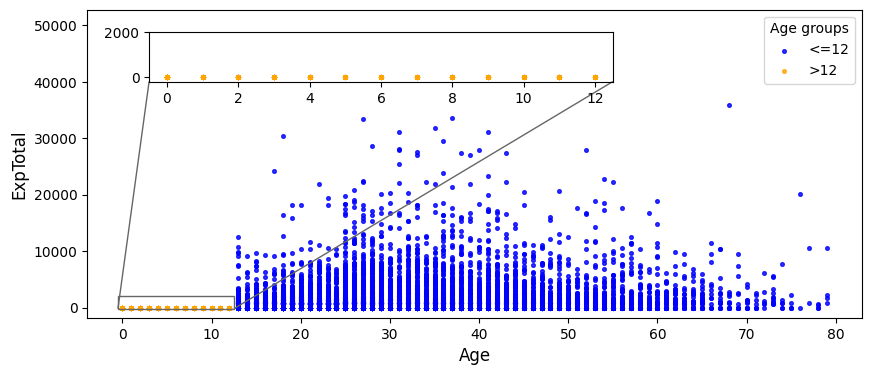

In [9]:
# Merge training and testing datasets:
all_df = pd.concat([train_df_SF, test_df_SF])
# Set age condition:
age_limit = 12 # Set age limit for zoomed-in plot
cond_age = all_df["Age"] <= age_limit

# Plot expenses vs age:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(all_df["Age"][~cond_age],all_df["ExpTotal"][~cond_age],s=7,alpha=0.8,color='blue',label='<=12')
ax.scatter(all_df["Age"][cond_age],all_df["ExpTotal"][cond_age],s=7,alpha=0.8,color='orange',label='>12')
ax.set_xlabel('Age',fontsize=12), ax.set_ylabel('ExpTotal',fontsize=12)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+15000)
ax.legend(title='Age groups')
# Zoomed-in image:
axins = zoomed_inset_axes(ax, 4, loc=6, bbox_to_anchor=[180,280,50,50])
axins.scatter(all_df["Age"][cond_age],all_df["ExpTotal"][cond_age],s=7,alpha=0.8,color='orange')
axins.set_xlim(-0.5, age_limit+0.5), axins.set_ylim(-200, 2000)
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.4") # Lines for inset image
plt.show()

Consequently, for passengers with feature **Age**<12, I will fill all expenses missing values as zero.

In [10]:
age_limit = 12 # Set age limit for zoomed-in plot
for dataset in [train_df_SF, test_df_SF]:
    idx = dataset["Age"][dataset["Age"] <= age_limit].index # Relevant indexes
    for feat in exp_features:
        dataset[feat].loc[idx] = 0 # Assign zero expenses for all categories
        dataset['ExpTotal'].loc[idx] = 0 # Assign zero total expenses
        dataset['Exp_zero'].loc[idx] = True # Assign Exp_zero

After this process, **131 missing values were corrected**.

(Remember you can call the function "compute_missing_values" at any step to see the number of missing values)

Now, let's turn the attention to the CryoSleeping passengers, who most probably could not spend anything during the trip:

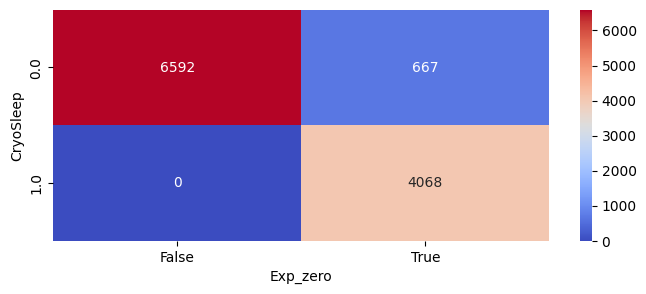

In [11]:
make_two_feature_chart(pd.concat([train_df_SF, test_df_SF]),'Exp_zero','CryoSleep',figsize=(8,3))

As expected, all those passengers who were cryo-sleeping (**CryoSleep**=1) spent nothing (**Exp_zero**=True) during the trip. Then, let's assign zero expenses to all those missing expenses values from sleeping passengers: 

In [12]:
for dataset in [train_df_SF, test_df_SF]:
    idx = dataset["CryoSleep"][dataset["CryoSleep"] == True].index # Relevant indexes
    for feat in exp_features:
        dataset[feat].loc[idx] = 0 # Assign zero expenses
        dataset['ExpTotal'].loc[idx] = 0 # Assign zero total expenses
        dataset['Exp_zero'].loc[idx] = True # Assign Exp_zero

This time, **467 missing values were corrected**!

And I have to stop here, as there no other certain rules for the other features. The **VIP** feature sounds like a good candidate for spending patterns, expecting that the wealthy passengers have some expenses. However, although most VIP people spent something, there are some exceptions, then I cannot make any assumptions:

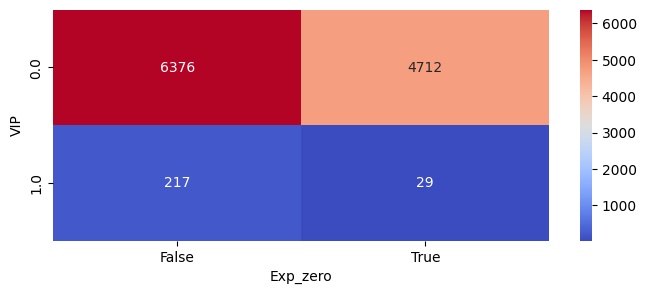

In [13]:
make_two_feature_chart(pd.concat([train_df_SF, test_df_SF]),'Exp_zero','VIP',figsize=(8,3))

<a id="Manual_data_correction_Cryosleep_Feature"></a>
## <span style="color:teal;font-weight:bold;">Cryosleep Feature</span>

As I demonstrated before, passengets who went to cryosleeping spent nothing during the trip.

Before, I corrected the missing expenses values by assigning zero expenses to all sleeping passengers. Now I'll do the converse operation: for any missing **CryoSleep** value, if the passenger spent something (**Exp_zero**=False), then that passenger was not cryosleeping, then **CryoSleep**=False.

In [14]:
for dataset in [train_df_SF, test_df_SF]:
    # Correct missing values:
    idx = (dataset['CryoSleep'].isna()) & (dataset['Exp_zero']==False) # Relevant indexes
    dataset['CryoSleep'].loc[idx] = 0

*Note*: in this process, the new feature **ExpTotal** sums all individual expenditures, including the NaN values! The NaN values are counted as 0. Although I did not analyze any of the expense features yet, I will tolerate this assumption for the **CryoSleep** analysis.

Let me summarize the progress so far for the **CryoSleep** feature: 
* Initial missing values: <span style="color:red">217 (2.5%) / 93 (2.2%)</span>.
* Current missing values: <span style="color:red">111 (1.3%) / 42 (1.0%)</span>.

<a id="Manual_data_correction_HomePlanet_Feature"></a>
## <span style="color:teal;font-weight:bold;">HomePlanet feature</span>

Passengers are organized in groups, identified by **IDgroup**. These groups have a common Home planet, as the next lines of code demonstrate:

In [15]:
def check_group_correlation(df,group_feat,target_feat):
    """
    Check if a target feature is univocally correlated with each unique value of
    the grouping feature. 
    --- Inputs ---
    {df} [Dataframe]: Dataset that will be analyzed.
    {group_feat} [String]: Name of the grouping features, from which the unique values
    will be considered.
    {target_feat} [String]: Name of the target feature to evaluate correlation.
    """
    n = 0 # Auxiliar counter
    for unique_val in set(df[group_feat]):
        # Make a set with all target values for the current grouping unique value (exclude NaN):
        target_values = set([x for x in df[df[group_feat]==unique_val][target_feat] if x==x])
        # If there is more than a single target value in the set, print on screen:
        if len(target_values)>1:
            n += 1
    # Inform conclusion:
    if n == 0:
        print(colored(
            f'{target_feat} is univocally correlated with each unique value of {group_feat}.','green'))
    else:
        print(colored(
            f'{target_feat} is NOT univocally correlated with each unique value of {group_feat}.','red'))
        print(f'There are {n} unique values in {group_feat} for which the univocally correlation is not valid.')

In [16]:
check_group_correlation(pd.concat([train_df_SF, test_df_SF]),'IDgroup','HomePlanet')

HomePlanet is univocally correlated with each unique value of IDgroup.


Consequently, any missing values in **HomePlanet** can be filled with the known destination of another passenger with the same **IDgroup**.

In [17]:
def correct_values_for_univocal_group_corr(dfs,group_feat,target_feat):
    """
    Correct missing values based for the target feature based on a univocal
    correlation with unique values of a grouping feature.
    --- Inputs ---
    {dfs} [List]: Each element is a pandas dataframe that will be considered for the
    univocal correlation and then corrected.
    {group_feat} [String]: Name of the grouping features, from which the unique values
    will be considered.
    {target_feat} [String]: Name of the target feature to evaluate correlation.
    """
    all_df = pd.concat(dfs) # Combine datasets
    # Apply corrections for each individual dataset: 
    for df in dfs:
        idx = df.loc[pd.isna(df[target_feat]), :].index # Relevant indexes (NaN values)
        # For each missing value, identify a known value for the grouping feature and correct the target feature:
        for i in idx:
            known_group_val = list(set(
                [x for x in all_df[all_df[group_feat]==df[group_feat][i]][target_feat] if x==x]))
            # Only proceed if there is a known grouping value (rather than only NaN):
            if len(known_group_val)>0:
                df[target_feat].loc[i] = known_group_val[0]

In [18]:
correct_values_for_univocal_group_corr(
    [train_df_SF, test_df_SF],"IDgroup","HomePlanet")

As there are still missing values in **HomePlanet**, I turn my attention to the correlation with the **Cabin_Deck** feature, as they are highly correlated (see section Correlations II in <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a>).

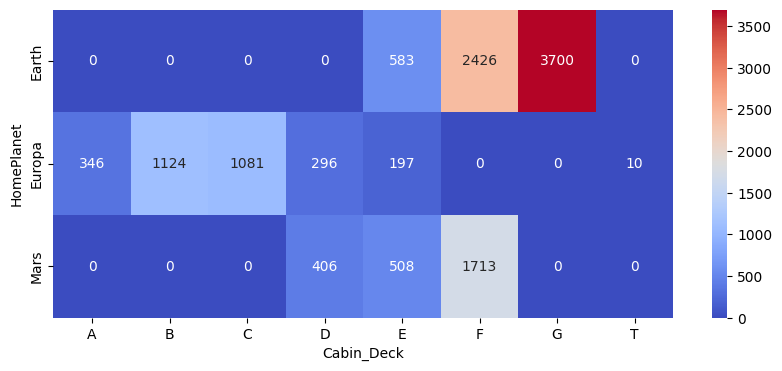

In [19]:
make_two_feature_chart(pd.concat([train_df_SF, test_df_SF]),'Cabin_Deck','HomePlanet',figsize=(10,4))

From this distribution plot, I can conclude the following:
- Passengers in **Cabin_Deck** A,B,C,T are associated with the **HomePlanet** Europa.
- Passengers in **Cabin_Deck** G are associated with the **HomePlanet** Earth.
- Passengers in **Cabin_Deck** D,E,F cannot be clearly assigned to a **HomePlanet**.

In [20]:
# Assign HomePlanet values based on Cabin:
for dataset in [train_df_SF, test_df_SF]:
    # Cabins A,B,C,T, associated to Europa:
    cond_ABCT = ((dataset["Cabin_Deck"]=="A") |
                 (dataset["Cabin_Deck"]=="B") |
                 (dataset["Cabin_Deck"]=="C") |
                 (dataset["Cabin_Deck"]=="T")) # Define condition
    dataset["HomePlanet"].loc[cond_ABCT] = "Europa" # Apply changes
    # Cabins G, associated to Earth:
    cond_G = dataset["Cabin_Deck"]=="G" # Define condition
    dataset["HomePlanet"].loc[cond_G] = "Earth" # Apply changes

Let's summarize the progress so far for the **HomePlanet** feature: 
* Initial missing values: <span style="color:red">201 (2.3%) / 87 (2.0%)</span>.
* Current missing values: <span style="color:red">63 (0.7%) / 31 (0.7%)</span>.

I have one last resource! Before, I grouped the passengers according to their **IDgroup** and correlated their **HomePlanet**. I will do the same with the **Name_Last** feature, and show that all passengers sharing the same surname belong to the same **HomePlanet**:

In [21]:
check_group_correlation(pd.concat([train_df_SF, test_df_SF]),'Name_Last','HomePlanet')

HomePlanet is univocally correlated with each unique value of Name_Last.


Consequently, any missing values in **HomePlanet** can be filled with the known destination of another passenger with the same **Name_Last**.

In [22]:
correct_values_for_univocal_group_corr(
    [train_df_SF, test_df_SF],"Name_Last","HomePlanet")

Excellent news, now the **HomePlanet** feature presents only a few missing values! 
* Current missing values: <span style="color:red">5 (0.1%) / 5 (0.1%)</span>.

<a id="Manual_data_correction_VIP_Feature"></a>
## <span style="color:teal;font-weight:bold;">VIP feature</span>

Very Important Passengers (**VIP**=True) have a diverse behavior in most of the features, including the expenses! However, I did find a patter regarding to their cabin location and surname popularity...
Let's take a look at the cabin deck first:

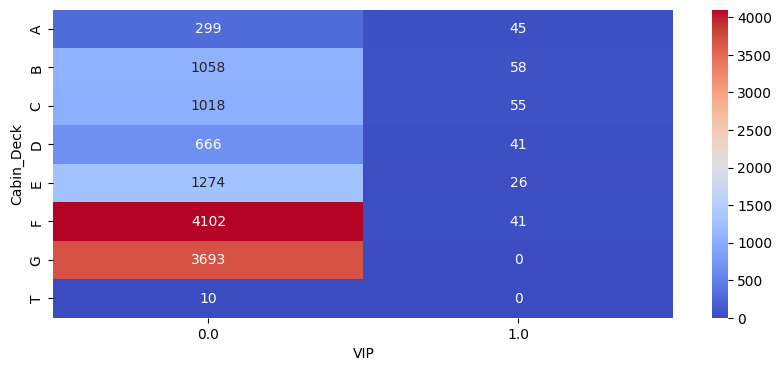

In [23]:
make_two_feature_chart(pd.concat([train_df_SF, test_df_SF]),'VIP','Cabin_Deck',figsize=(10,4))

From this chart, we can conclude that **VIP**=True passenger do not stay in **Cabin_Deck**=G or T (although the last case is not very reliable, as there are only 10 values). Let's check how many NaN values for the **VIP** feature are for these cabin decks:

In [24]:
# Combine datasets and prepare condition:
all_df = pd.concat([train_df_SF, test_df_SF])
cond_cabin = ((all_df['VIP'].isna()) &
    ((all_df['Cabin_Deck']=='G') | (all_df['Cabin_Deck']=='T')))
# Count the number of ocurrences for each "Cabin_Deck" for NaN VIP values:
all_df[['VIP','Cabin_Deck']].loc[cond_cabin]['Cabin_Deck'].value_counts()

Cabin_Deck
G    88
T     1
Name: count, dtype: int64

I will leave that 'T' row apart and only correct the 'G' rows:

In [25]:
for dataset in [train_df_SF, test_df_SF]:
    # Correct missing values:
    idx = (dataset['VIP'].isna()) & (dataset['Cabin_Deck']=='G') # Relevant indexes
    dataset['VIP'].loc[idx] = 0

Lastly, I'll show a very strong correlation between the **VIP** and **Ocurrence_LastName** features, probably meaning that VIP passengers do not have too popular last names...

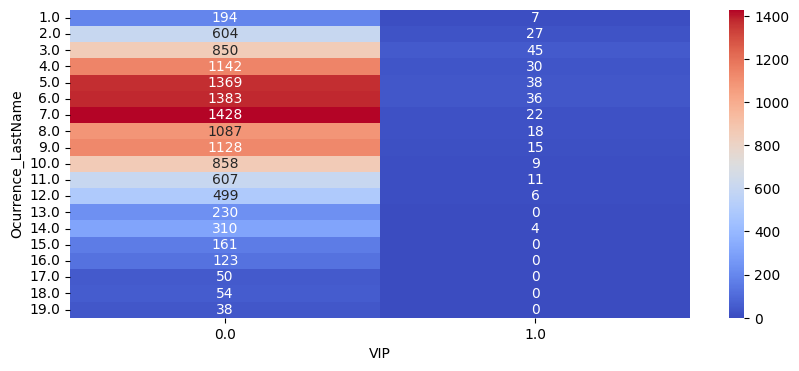

In [26]:
make_two_feature_chart(pd.concat([train_df_SF, test_df_SF]),'VIP','Ocurrence_LastName',figsize=(10,4))

It seems that **Ocurrence_LastName**>14 implies **VIP**=False, but this rule may be misleading, as the VIP True values are very scarce, then making statistics is not very reliable. For example, **Ocurrence_LastName**=14 and 12 have VIP rates of approximate 0.013 and 0.012, which are very low but not zero. Then, finding a **VIP**=True value for very high **Ocurrence_LastName** is very rare, but it is possible according to the low rates.

For this edition process, in which I'm using "all or nothing" rules, I will not use the **Ocurrence_LastName** feature to correct the **VIP** missing values. And anyway, the amount of missing **VIP** values that may be corrected is very small:

In [27]:
# Combine datasets and prepare condition:
all_df = pd.concat([train_df_SF, test_df_SF])
cond_cabin = ((all_df['VIP'].isna()) &
    ((all_df['Ocurrence_LastName']>14)))
# Count the number of ocurrences for each "Ocurrence_LastName" for NaN VIP values:
all_df[['VIP','Ocurrence_LastName']].loc[cond_cabin]['Ocurrence_LastName'].value_counts()

Ocurrence_LastName
16.0    4
15.0    2
Name: count, dtype: int64

<a id="Manual_data_correction_Cabin_isPort_Feature"></a>
## <span style="color:teal;font-weight:bold;">Cabin_isPort feature</span>

Similar to the **HomePlanet** and **IDgroup** correlation, passengers who share the same **IDgroup** are located in the same **Cabin_isPort**:

In [28]:
check_group_correlation(pd.concat([train_df_SF, test_df_SF]),'IDgroup','Cabin_isPort')

Cabin_isPort is univocally correlated with each unique value of IDgroup.


Then, I will fill any **Cabin_isPort** missing values with a known value from the same **IDgroup**:

In [29]:
correct_values_for_univocal_group_corr(
    [train_df_SF, test_df_SF],"IDgroup","Cabin_isPort")

In this way, 137 missing **Cabin_isPort** were corrected.

<a id="Manual_data_correction_checkpoint"></a>
## <span style="color:teal;font-weight:bold;">Checkpoint: Manual correction</span>

Manual correction is finished! Using completely certain correlations, I have corrected missing values from many features. If I were to take some risks in filling missing values, I could use "high probability" rules, such as the one relating the **VIP** feature with **Ocurrence_LastName**. However, I will leave this job the ML data imputation algorithm, explained later.

Let's check the updated missing values:

In [30]:
compute_missing_values(train_df_SF,test_df_SF)


Missing values in train/test datasets:

HomePlanet:              5 (0.1%) / 5 (0.1%)
CryoSleep:            111 (1.3%) / 42 (1.0%)
Destination:          182 (2.1%) / 92 (2.2%)
Age:                  179 (2.1%) / 91 (2.1%)
VIP:                  137 (1.6%) / 71 (1.7%)
ExpRS:                107 (1.2%) / 55 (1.3%)
ExpFC:                106 (1.2%) / 65 (1.5%)
ExpSM:                103 (1.2%) / 60 (1.4%)
ExpSpa:               114 (1.3%) / 52 (1.2%)
ExpVR:                107 (1.2%) / 43 (1.0%)
IDgroup:                 0 (0.0%) / 0 (0.0%)
GroupMembers:            0 (0.0%) / 0 (0.0%)
Cabin_Deck:          199 (2.3%) / 100 (2.3%)
Cabin_num:           199 (2.3%) / 100 (2.3%)
Cabin_isPort:          99 (1.1%) / 63 (1.5%)
Name_Last:            200 (2.3%) / 94 (2.2%)
Ocurrence_LastName:   200 (2.3%) / 94 (2.2%)
ExpTotal:            518 (6.0%) / 267 (6.2%)
Exp_zero:            518 (6.0%) / 267 (6.2%)

Number of rows with 0 missing values: 7259/3572
Number of rows with 1 missing values: 523/243
Number of

<a id="Preliminary_submission_results"></a>
## <span style="color:teal;font-weight:bold;">Preliminary submission results</span>

The data edition process is not finished yet, but I would like to measure the improvement so far by missing the missing values with the completely reliable manual correction. As a reference benchmark, I will use the previous 0.80336 that I obtained in my notebook <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering</a>.

As ML models, I will use simple choices, the same as in the mentioned notebook. As some of these models require that the dataset is clean of NaN values, I assign simple corrections based on the mean value for numerical features, or the most frequent value for non-numerical features.

In [31]:
# Simple correction for dataset:
def simple_data_correction(df,target_col='Transported'):
    """
    Corrects missing values using the average value for numeric features
    or most frequent value for non-numeric features.
    --- Inputs ---
    {df} [Dataframe]: Dataframe to be corrected.
    {target_col} [String]: Target column in the dataframe (won't be corrected)
    --- Outputs ---
    {df_corrected} [Dataframe]: Corrected Dataframe.
    """
    df_corrected = df.copy()
    # Determine column types:
    col_numeric = [col for col in df.columns if 
                   df[col].dtypes != 'object' and col!=target_col]
    col_object = [col for col in df.columns if 
                  col not in col_numeric and col!=target_col]
    # Correct numeric columns:
    for col in col_numeric:
        df_corrected[col] = df[col].fillna(value=df[col].mean())
    # Correct non-numeric columns:
    for col in col_object:
        most_freq = df[col].value_counts(sort=True).index[0]
        df_corrected[col] = df[col].fillna(value=most_freq)
    return df_corrected

In [32]:
import matplotlib.patches as patches

def encode_and_correlation(df,max_cats=10,target_col='Transported',
                           c_thres=0.1,plot_corr=True):
    """
    Encodes non-numeric features in a dataset and plots the correlation matrix.
    --- Inputs ---
    {df} [dataframe]: Dataframe to be encoded.
    {max_cats} [int]: Maximum number of categories for a non-numeric
    feature to be encoded. If the feature has more categories, it is ignored.
    {ref_col} [string]: Target column, it won't be encoded.
    {c_thres} [float]: Threshold correlation value, only exceeding values
    will be painted in the correlation matrix.
    {plot_corr} [boolean]: If True, plots the correlation matrix. If False, 
    doesn't plot it, but still returns the encoded dataframe.
    --- Outputs ---
    {df_enc} [dataframe]: Encoded dataframe.
    """
    # ===== ENCODING ===== 
    # One-Hot encode non-numerical features with few unique values:
    feat_enc = [feat for feat in df.columns if 
                df[feat].dtype == 'object' and # Numeric or...
                df[feat].nunique()<=max_cats] # ...Few unique values

    # Encode features:
    if len(feat_enc)>1:
        data_enc = pd.get_dummies(df[feat_enc])
        # Prepare dataframes having only numeric/boolean features:
        df_enc = pd.concat([df, data_enc], axis=1)
    else:
        df_enc = df.copy()
    # Sort columns alphabetically, but leave 'Transported' at the beggining in training dataset:
    df_enc = df_enc.reindex(sorted(df_enc.columns), axis=1)
    if target_col in df_enc:
        df_enc = df_enc[['Transported'] + [col for col in df_enc.columns
                                           if col != target_col ]]
    else:
        df_enc = df_enc[[col for col in df_enc.columns]]
    # Drop source-encoded features: 
    df_enc = df_enc.drop(feat_enc,axis=1)
    # Drop not suitable features:
    feat_not_enc = [feat for feat in df.columns if
                    df[feat].dtype == 'object' and # Numeric or...
                    df[feat].nunique()>10] # ...Few unique values
    df_enc = df_enc.drop(feat_not_enc,axis=1)
    
    # ===== CORRELATION MATRIX ===== 
    if plot_corr:
        # Prepare data:
        corr = df_enc.corr() # Obtain correlations
        trimask = np.triu(np.ones_like(corr, dtype=bool)) # Mask upper triangle in correlations    
        # Plot correlations in training dataset:
        fig, ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(corr, ax=ax, square=True,cmap='coolwarm',
                    vmin=-1, vmax=1, linecolor='w',lw=0.5, 
                    mask=trimask | (np.abs(corr) <= c_thres))
        # Separate the target correlations:
        ax.plot([1,1],[1,len(df_enc.columns)],color='k',lw=2)
        # Draw the correlations' triangle:
        ax.plot([1,len(df_enc.columns)],[1,len(df_enc.columns)],color='k',lw=0.5)
        ax.plot([1,len(df_enc.columns)],[len(df_enc.columns),len(df_enc.columns)],
                color='k',lw=1.5)
        # Identify blocks of similar features:
        main_name = [feat.split('_')[0] for feat in list(df_enc.columns)]
        index_counts = [(main_name.index(name),main_name.count(name))
                        for name in sorted(set(main_name))]
        for index, counts in index_counts:
            if counts>1: 
                triangle = [[index, index],
                            [index+counts, index+counts],
                            [index, index+counts]]
                ax.add_patch(patches.Polygon(triangle, edgecolor="k",facecolor='none',ls="--",lw=2))
        ax.set_title(f"Dataset Correlations", size=15)
        fig.tight_layout()
        plt.show()    
    
    return df_enc

In [33]:
# Train ML models and export the submission file:
from sklearn.ensemble import (
RandomForestClassifier,
RandomForestRegressor,
GradientBoostingClassifier,
GradientBoostingRegressor
)
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier,XGBRegressor)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

def train_submit_ML(model,train_df,test_df):
    """
    Trains a ML model, and saves the submission file.
    --- Inputs ---
    {model} [Machine Learning model]: ML model to be trained.
    {train_df} [Dataframe]: Training dataset, it must contain the
    columns "PassengerId" and "Transported".
    {test_df} [Dataframe]: Testing dataset, it must contain the
    column "PassengerId".
    --- Outputs ---
    {train_score} [Float]: Training score.
    """
    # Extract PassengerId and Transported columns, if applicable:
    passID_train = train_df['PassengerId']
    passID_test = test_df['PassengerId']
    y_train = train_df['Transported']
    x_train = train_df.drop(['PassengerId','Transported'],axis=1)
    x_test = test_df.drop('PassengerId',axis=1)
    # Initialize model with fixed seed if possible:
    if 'random_state' in dir(model):
        model.random_state = 0 
    # Train the model:
    model.fit(x_train,y_train)
    train_score = model.score(x_train,y_train) # Get training score
    # Make submission:
    preds = model.predict(x_test)
    preds = preds.astype(bool) # Ensure the values are boolean
    df_subm = pd.DataFrame({
        "PassengerId": passID_test,
        "Transported": preds
    }).to_csv('submission.csv', index=False)
    # Final output and message:
    print("Training score:", np.round(train_score,4))
    print("Submission file ready.")
    return train_score, preds

In [62]:
# Prepare datasets for submission:
# 1. Simple corrections.
# 2. One-Hot encoding.
# 3. Add the PassengerID column.
df_train_submit = encode_and_correlation(
    simple_data_correction(train_df_SF),plot_corr=False)
df_train_submit['PassengerId'] = train_ID
df_test_submit = encode_and_correlation(
    simple_data_correction(test_df_SF),plot_corr=False)
df_test_submit['PassengerId'] = test_ID

# Some ML Options:
# RandomForestClassifier(n_estimators=100, max_depth=5)
# GradientBoostingClassifier(n_estimators=100, max_depth=3)
# XGBClassifier(n_estimators=100, max_depth=3)

# Define and train simple model:   
model = XGBClassifier(n_estimators=100, max_depth=2)
# Uncomment this line to train the model:
# train_score, preds = train_submit_ML(model,df_train_submit,df_test_submit)

The following results have been obtained after submitting different solutions to the Kaggle competition:

In [35]:
from matplotlib.pyplot import cm

def plot_training_submission_scores(df_results,sort_by='Model',benchmark=None):
    """
    Plots training vs submission scores, grouped by ML groups.
    --- Inputs ---
    {df_results} [DataFrame]: Results for all trained groups, 
    must include the following columns:
    'Model','train_score','subm_score', and the {sort_by} feature.
    {sort_by} [String]: Feature by which the results are grouped.
    {benchmark} [Float or None]: benchmark score. Select None if there is none.
    """
    # Identify groups:
    groups = sorted(set(df_results[sort_by])) 
    
    # Plot figures:
    markers = ["o","<","s","d","v","p","P","^","*","D",">"]
    colors_groups = cm.turbo(np.linspace(0, 1, len(groups)))
    fig, ax = plt.subplots(figsize=(7,4))
    for j,group in enumerate(groups):
        data = df_results[df_results[sort_by]==group]
        ax.scatter(data['subm_score'],data['train_score'],
                   marker=markers[(j) % len(markers)],
                   s=70,edgecolor='k',color=colors_groups[j],
                   alpha=0.7,label=sort_by+' '+group)    
    range_subm_score = [min(df_results['subm_score'])*0.995,
                        max(df_results['subm_score'])*1.005]
    if benchmark is not None:
        ax.axvline(benchmark,ls=':',lw=1.5,color='b',
                   label='Benchmark',alpha=0.8)
    ax.plot(range_subm_score,range_subm_score,'--k',alpha=0.5,
            label='Ideal training')
    ax.set(xlabel="Submission Score",ylabel="Training score")
    ax.legend(ncol=1,loc='upper left')
    fig.tight_layout()
    plt.show()

Top 3 models:


,Model,max_depth,n_estimators,subm_score,train_score
9,GradientBoostingClassifier,5,90,0.80687,0.8743
3,GradientBoostingClassifier,5,100,0.80617,0.8779
10,GradientBoostingClassifier,5,110,0.80617,0.8808


Training vs Submission scores for all models:


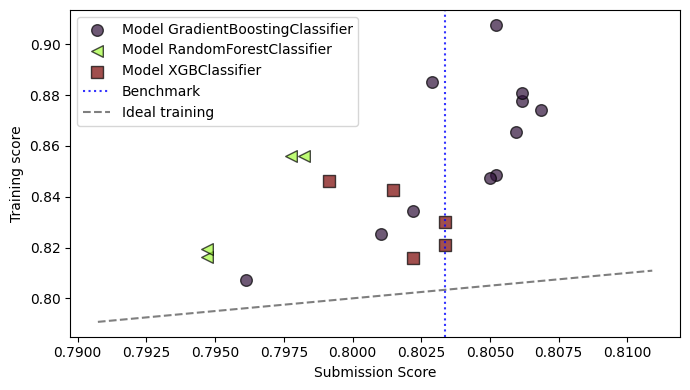

In [52]:
# Load pre-trained results:
df_results = pd.read_csv('kaggle/Training_results/03_Data_imputation_submissions_only_manual_corrections.csv')
# Display table with 5 best models:
print('Top 3 models:')
display(df_results[
    ["Model","max_depth","n_estimators","subm_score","train_score"]
].sort_values(["subm_score"],ascending=False).head(3))
# Plot training vs submission scores:
print('Training vs Submission scores for all models:')
plot_training_submission_scores(df_results,sort_by='Model',
                                benchmark=0.80336)

Good news: **after the manual data edition**, the submission score has already improved compared to the previous benchmark, reaching a **new best submission score of 0.80687**.

<a id="ML_data_imputation"></a>
# <span style="color:teal;font-weight:bold;">ML data imputation</span>

Let's begin with the challenge of designing a Machine Learning data imputation method. Following the same spirit of this competition, which is to predict the **Transported** feature of a passenger based on the other features, the idea is to correct the missing values for each row based on the known values of the remaining features.

My ML data imputation is designed for each feature separately (namely the target feature), and has two stages:

1. Optimization using a reduced dataset of complete rows, without any missing values, which are split in a training and testing dataset. The most accurate ML model along with its hyperparameters are chosen.
2. Train the ML model using all rows without missing values in the target feature, and then predict the missing values and impute those values in the dataset.

I consider the following scores for the ML models, depending on the classification or regression task:

- **Accuracy**, for classification. Defined as the number of correct predicted values divided by the total number of predictions.
- **Mean Absolute Error (MAE)**, for regression. Defined as the average value for the absolute difference between the predicted values and the ground truth.

It is important to note that features that have an object type are trained with classification ML models, except for boolean features, such as **CryoSleep**. These features, along with all numeric-type features, are trained with regression ML models. For boolean features, however, predictions are converted from continuous numbers to boolean values by applying a threshold criterion: all values equal or smaller than 0.5 are turned into False, values greater than 0.5 to True. The scoring method for boolean feature is then Accuracy, the same as for classification methods.

The ML model for data imputation will be trained with all the features, including original and engineered, but it will correct only the following ones:

**HomePlanet**, **CryoSleep**, **Destination**, **Age**, **VIP**, **ExpRS**, **ExpFC**, **ExpSM**, **ExpSpa**, **ExpVR**, **Cabin_Deck**, **Cabin_num**, **Cabin_isPort**.

The features **ExpTotal** and **Exp_zero** will be calculated again based on the corrected expenses features.

The features **IDgroup** and **GroupMembers** are already complete, so there is no need for data imputation.

The features **Name_Last** and **Ocurrence_LastName** will be dropped after the ML imputation process.

<a id="ML_data_imputation_first_stage"></a>
## <span style="color:teal;font-weight:bold;">First stage: ML optimization</span>

The following lines define the optimization function, which is in fact a manual grid search. I only consider Random Forest Estimator and Gradient Boosting ML models, in their classification and regression versions, and variations for the hyperparameters "n_estimators" and "max_depth". Of course, a larger search with more options can be implemented, users are very welcome to adapt my method.

Because optimization can take a long time, I just summarize my results and avoid running the function. However, the users can just uncomment the lines and try by themselves.

In [37]:
from sklearn.model_selection import train_test_split

def ML_data_imp_optim(dfs,target_feat,n_est_options=[50,100],
                      max_d_options=[3,5,7],
                      drop_feats=['Name_Last','IDgroup','Transported']):
    """
    Optimize Machine Learning model for imputing missing values for a target feature, 
    using the known values of the other features.
    --- Inputs ---
    {dfs} [List]: Each element is a pandas dataframe that will be considered for the
    univocal correlation and then corrected.
    {target_feat} [String]: Name of the target feature.
    {n_est_options} [List]: Options for number of estimators, common to all ML models.
    {mad_d_options} [List]: Options for maximum depth, common to all ML models.
    {drop_feats} [List]: Each element is a feature from the input datasets that
    will be dropped, then it will not participate in the data imputation process.
    """
    # Initiate variables, concatenate datasets and drop selected features:
    df_all = pd.concat(dfs) # Combine datasets
    df_all = df_all.drop(drop_feats,axis=1)
    # One-Hot Encode object features (other than the target feature):
    feats_enc = [feat for feat in df_all.columns if 
                 df_all[feat].dtype=='object' and feat!=target_feat]
    data_enc = pd.get_dummies(df_all[feats_enc])
    df_all = pd.concat([df_all, data_enc], axis=1)
    # Drop source-encoded features: 
    df_all = df_all.drop(feats_enc,axis=1)   

    # Prepare training and testing datasets to select ML model:  
    df_all_full = df_all[~df_all.isnull().any(axis=1)] # Identify complete rows    
    df_train, df_test = train_test_split(df_all_full, test_size=0.25) # Split train/test datasets
    x_train = df_train.drop([target_feat],axis=1)
    y_train = df_train[target_feat]
    x_test = df_test.drop(target_feat,axis=1)
    y_test = df_test[target_feat]

    # Identify if feature's type is 'object' or not:
    is_object = True if df_all[target_feat].dtype=='object' else False
    # If not object, then check if it is in fact boolean:
    is_boolean = True if len(set(df_all_full[target_feat]))==2 and not is_object else False
    is_numeric = True if (not is_object and not is_boolean) else False
    
    # Prepare ML models according to classification task:
    if is_object:
        models = {'Random Forest Classifier':RandomForestClassifier(),
                  'Gradient Boosting Classifier':GradientBoostingClassifier()}
    else:
        models = {'Random Forest Regressor':RandomForestRegressor(),
                  'Gradient Boosting Regressor':GradientBoostingRegressor()}
    # Train and test ML models and keep the best:
    n_est_best, max_d_best, best_model, best_score = 'None','None','None',0 # Initiate
    best_score = 0 if not is_numeric else 1e6
    for model in models:
        ML_model = models[model]
        for n_est in n_est_options:
            for max_d in max_d_options:
                # Prepare ML model:
                ML_model.random_state = 0 # Set random seed
                ML_model.n_estimators = n_est # Set number of estimators
                ML_model.max_depth = max_d # Set maximum depth
                # Train the model, predict target feature:
                ML_model.fit(x_train,y_train) # Train the model
                preds = ML_model.predict(x_test) # Predict target feature
                # If target feature is boolean, transform to 0/1:
                if is_boolean:
                    preds = (preds > .5).astype(float)
                # Assign score:
                if is_object or is_boolean: # Classification, accuracy score
                    score = sum(preds==y_test)/len(preds)
                else: # Regression, average error score:
                    score = np.mean(np.abs(preds-y_test))
                # Update best model and benchmaks:
                if (score > best_score and not is_numeric) or (score < best_score and is_numeric):
                    best_score = score
                    best_model = model
                    n_est_best = n_est
                    max_d_best = max_d
    print('Best model for',colored(target_feat,attrs=['bold']),':')
    print(f'{best_model}, {n_est_best} estimators, max depth {max_d_best}')
    if is_object or is_boolean:
        print(f'Accuracy score (classification): {best_score:.4f}.\n')
    else:
        print(f'Average error (regression): {best_score:.2f} (mean value {np.mean(df_all_full[target_feat]):.2f}).\n')

In [38]:
# Initiate new dataset variables:
target_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
                'ExpRS', 'ExpFC', 'ExpSM', 'ExpSpa', 'ExpVR', 'Cabin_Deck',
                'Cabin_num', 'Cabin_isPort']
# The following options for hyperparameters are examples from my last fine tuning:
hyps_dict = {
    'HomePlanet': {'n_est_opts': [250,300,350], 'max_d_opts': [6,7,8]},
    'CryoSleep': {'n_est_opts': [400,500,600], 'max_d_opts': [4,5,6]},
    'Destination': {'n_est_opts': [75,100,125], 'max_d_opts': [2,3,4]},
    'Age': {'n_est_opts': [30,50,70], 'max_d_opts': [4,5,6]},
    'VIP': {'n_est_opts': [30,50,70], 'max_d_opts': [8,9,10]},
    'ExpRS': {'n_est_opts': [400,500,600], 'max_d_opts': [4,5,6]},
    'ExpFC': {'n_est_opts': [400,500,600], 'max_d_opts': [2,3,4]},
    'ExpSM': {'n_est_opts': [400,500,600], 'max_d_opts': [4,5,6]},
    'ExpSpa': {'n_est_opts': [400,500,600], 'max_d_opts': [2,3,4]},
    'ExpVR': {'n_est_opts': [400,500,600], 'max_d_opts': [2,3,4]},
    'Cabin_Deck': {'n_est_opts': [200,300,400], 'max_d_opts': [8,9,10]},
    'Cabin_num': {'n_est_opts': [150,200,250], 'max_d_opts': [6,7,8]},
    'Cabin_isPort': {'n_est_opts': [250,300,350], 'max_d_opts': [8,9,10]},
}

# Uncomment the following lines if you want to run the ML optimization process:
# Impute missing values using ML:
# for feat in target_feats:
#     # Correct missing values on single feature for both training and testing datasets:
#     n_est_options = hyps_dict[feat]['n_est_opts']
#     max_d_options = hyps_dict[feat]['max_d_opts']
#     ML_data_imp_optim([train_df_SF,test_df_SF],feat,
#                       n_est_options=n_est_options,max_d_options=max_d_options)

In the following table, GBC means Gradient Boosting Classifier, GBR means Gradient Boosting Regressor, RFC means Random Forest Classifier and RFE means Random Forest Regressor. The scores are provided according to the classification (Cla.) or regression (Reg.) task of the ML model. To have a reference for the MAE score, the mean value of the feature in the training dataset is included.

| Feature | ML model | n_estimators | max_depth | Accuracy (Cla.) | MEA (Reg.) | Mean value (Reg.) |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| **HomePlanet** | GBC | 300 | 6 | **0.9707** | - | - |
| **CryoSleep** | RFR | 400 | 5 | **0.9556** | - | - |
| **Destination** | GBC | 100 | 3 | **0.7006** | - | - |
| **Age** | GBR | 50 | 5 | - | **9.74** | 28.64 |
| **VIP** | RFR | 50 | 9 | **0.9823** | - | - |
| **ExpRS** | GBR | 500 | 5 | - | **61.28** | 212.26 |
| **ExpFC** | GBR | 600 | 3 | - | **59.70** | 439.83 |
| **ExpSM** | GBR | 500 | 5 | - | **60.22** | 169.16 |
| **ExpSpa** | GBR | 600 | 4 | - | **71.01** | 296.41 |
| **ExpVR** | GBR | 500 | 3 | - | **64.85** | 288.30 |
| **Cabin_Deck** | GBC | 300 | 9 | **0.8273** | - | - |
| **Cabin_num** | RFR | 200 | 8 | - | **299.97** | 604.68 |
| **Cabin_isPort** | GBR | 300 | 9 | **0.5437** | - | - |

In general, the ML performance is pretty good for the different features, much better than a random choice. For example, guessing a random value for a missing value in the **Destination** feature has a 33% success chance, but the ML prediction has a 70% success rate.

For the **Age** and expenses numerical features, the MAE is low compared to the mean value, which is a good indicator. The prediction for **Cabin_num** does not look very good, as the cabin number is in average confused by 300 units.

Lastly, the ML performance on the **Cabin_isPort** feature is very poor, just above 50%, which is almost equivalent to a random choice.

<a id="ML_data_imputation_second_stage"></a>
## <span style="color:teal;font-weight:bold;">Second stage: Data imputation</span>

So far, I have optimized a Machine Learning model for each target feature (**HomePlanet**, **CryoSleep**, **Destination**, **Age**, **VIP**, **ExpRS**, **ExpFC**, **ExpSM**, **ExpSpa**, **ExpVR**, **Cabin_Deck**, **Cabin_num**, **Cabin_isPort**) based on the full rows of the combined training and testing datasets.

The next step is to impute values for the missing rows of each feature. The process will be iterative, meaning that once a feature is corrected, the training and testing datasets will be updated and there won't be any missing values in that feature. 

While in the optimization process I used a restricted dataset with only full rows to train the ML model, now I have to deal with missing values for predictions! Remember that each ML model takes as input all values in a single row except for the target feature, which has to be predicted. Then, for those rows with multiple missing values, I need to somehow correct those values other than the target feature. My strategy is the following:

1. **Order features by missing values, in ascending order**. As the imputation process updates the datasets for each corrected feature, I will minimize the impact of imputed features by correcting the features with less missing values first.
2. **For each target feature, set the training dataset** for the ML imputation model as the combination of the training and testing datasets, excluding the rows with missing values for the target feature.
3. **Virtually correct the training dataset** using the average value for numerical features and the mode value for non-numerical features.
4. **Train the ML imputation model using the previously optimized hyperparameters**.
5. **Predict the missing values for the target feature**.
6. **Update the training and testing datasets** with the predicted values for the **target feature**. Note that the virtual corrections on all other missing values corresponding to other features will not be included.
7. **Repeat steps 2-6 with the remaining target features**, until all target features have been corrected.

In [39]:
def simple_correction_feat(df,feat):
    """
    Correct a single feature in the dataset using the average value for a numerical feature
    or the most frequent value for a non-numerical feature.
    --- Inputs ---
    {df} [Dataframe]: Dataframe to be corrected.
    {feat} [String]: Target column in the dataframe that will be corrected.
    --- Outputs ---
    {df_corrected} [Dataframe]: Corrected Dataframe.
    """
    df_corrected = df.copy() # Initiate corrected dataset
    # Determine feature type:
    feat_num = True if df[feat].dtypes != 'object' else False
    # Correct feature:
    if feat_num:
        df_corrected[feat] = df[feat].fillna(value=df[feat].mean())
    else:
        most_freq = df[feat].value_counts(sort=True).index[0]
        df_corrected[feat] = df[feat].fillna(value=most_freq)
        
    return df_corrected

In [40]:
from sklearn.model_selection import train_test_split

def ML_data_imp_correct(dfs,target_feat,ML_model):
    """
    Impute missing values for a target value using a Machine Learning algorithm, based
    on the known values of the other features.
    --- Inputs ---
    {dfs} [List]: Each element is a pandas dataframe that will be considered for the
    univocal correlation and then corrected.
    {target_feat} [String]: Name of the target feature.
    {ML_model} [sklearn ML model]: Machine Learning object with defined hyperparameters. 
    --- Returns ---
    {y_test_list} [List]: Each element is a pandas series for the imputed target features,
    including the original non-NaN values and the corrected ones, correlated with the input datasets.
    """
    # 0. Prepare variables:
    feat_imps = [] # Initiate imputed features for each input dataset
    input_feats = [feat for feat in dfs[0] if feat!=target_feat]
    index_nan = [df[target_feat].isna() for df in dfs] # Identify NaN indexes
    # Combine datasets for training purposes, only rows which are not nan:
    x_train = pd.concat([dfs[i].loc[~index_nan[i]][input_feats] for i in range(len(dfs))])
    y_train = pd.concat([dfs[i].loc[~index_nan[i]][target_feat] for i in range(len(dfs))])
    # Identify target column:
    y_test_list = [df[target_feat] for df in dfs]
    
    # 1.A Fill missing values with average/mode for all features except target, in training datasets:
    for feat in x_train:
        x_train = simple_correction_feat(x_train,feat)
    # One-Hot Encode object features:
    feats_enc = [feat for feat in x_train if x_train[feat].dtype=='object']
    data_enc = pd.get_dummies(x_train[feats_enc])
    x_train = pd.concat([x_train, data_enc], axis=1)
    # Drop source-encoded features: 
    x_train = x_train.drop(feats_enc,axis=1)

    # 1.B Fill missing values with average/mode for all features except target, in testing datasets:
    dfs_test = [] # Initiate list with all testing datasets
    for i in range(len(dfs)):
        # Make simple corrections:
        for feat in dfs[i]:
            if dfs[i][feat].isna().sum()>0:
                dfs[i] = simple_correction_feat(dfs[i],feat)
        # Identify rows with missing values of the target feature:
        x_test = dfs[i].loc[index_nan[i]][input_feats] 
        # One-Hot Encode object features:
        feats_enc = [feat for feat in x_test if x_test[feat].dtype=='object']
        data_enc = pd.get_dummies(x_test[feats_enc])
        x_test = pd.concat([x_test, data_enc], axis=1)
        # Drop source-encoded features: 
        x_test = x_test.drop(feats_enc,axis=1)
        # Add testing dataset to the list:
        dfs_test.append(x_test)
    
    # 1.C Only keep features which are common to all datasets:
    common_cols = set([col for col in x_train]) # Initiate list with all features in training dataset
    for df in dfs_test:
        common_cols = common_cols.intersection(set([col for col in df]))
    common_cols = list(common_cols) # Convert into list to fix order
    x_train = x_train[common_cols]
    for i in range(len(dfs_test)):
        dfs_test[i] = dfs_test[i][common_cols]
        
    # 2. Train the ML model
    ML_model.fit(x_train,y_train) # Train the model
    print(f'Target feature: {target_feat}.')
    print(f'ML model trained with {len(x_train)} rows.')
    N_nan = int(sum(np.array([len(df) for df in dfs_test])))
    print(f'Number of missing values to be corrected: {N_nan}.\n')

    # 3. Predict target feature
    is_boolean = True if (y_train.dtype!='object' and len(set(y_train))==2) else False # Check if target is boolean
    for i in range(len(dfs_test)):
        # Make predictions:
        preds = ML_model.predict(dfs_test[i]) # Predict target feature
        # If target is boolean, convert to True/False and then to target feature's format
        if is_boolean:
            preds = (preds > .5).astype(float)
            preds = preds.astype(y_train.dtype)
        feat_imps.append(preds)

    # Correct target column for each dataset in dfs:
    for i_df in range(len(dfs_test)):
        for j_idx in range(len(dfs_test[i_df])):
            idx = dfs_test[i_df].index[j_idx]
            y_test_list[i_df].at[idx] = feat_imps[i_df][j_idx]
    
    return y_test_list

In [41]:
best_hyps = {
    'HomePlanet': {'ML_model':'GBC','n_est': 300, 'max_d': 6},
    'CryoSleep': {'ML_model':'RFR','n_est': 400, 'max_d': 5},
    'Destination': {'ML_model':'GBC','n_est': 100, 'max_d': 3},
    'Age': {'ML_model':'GBR','n_est': 50, 'max_d': 5},
    'VIP': {'ML_model':'RFR','n_est': 50, 'max_d': 9},
    'ExpRS': {'ML_model':'GBR','n_est': 500, 'max_d': 5},
    'ExpFC': {'ML_model':'GBR','n_est': 600, 'max_d': 3},
    'ExpSM': {'ML_model':'GBR','n_est': 500, 'max_d': 5},
    'ExpSpa': {'ML_model':'GBR','n_est': 600, 'max_d': 4},
    'ExpVR': {'ML_model':'GBR','n_est': 500, 'max_d': 3},
    'Cabin_Deck': {'ML_model':'GBC','n_est': 300, 'max_d': 9},
    'Cabin_num': {'ML_model':'RFR','n_est': 200, 'max_d': 8},
    'Cabin_isPort': {'ML_model':'GBR','n_est': 300, 'max_d': 9},    
}

In [43]:
def sort_features(df,target_feats):
    """
    Sort features in a dataset according to the number of NaN values, from lower to higher.
    --- Inputs ---
    {df} [DataFrame]: Dataframe for which the features will be sorted.
    {target_feats} [List]: Each element is a feature that will be sorted.
    --- Returns ---
    {sorted_feats} [List]: Sorted features, in ascending order of NaN values.
    """
    # Generate dictionary with number of NaN values for each target feature:
    N_nan = {feat: 0 for feat in target_feats} # Initiate counter for NaN values
    for feat in target_feats:
        N_nan[feat] = int(df[feat].isna().sum())
    # Sort features by number of NaN values in ascending order:
    sorted_feats = [feat_N[0] for feat_N in sorted(N_nan.items(), key=lambda item: item[1])]
    
    return sorted_feats

Before running the complete ML data imputation process, I've analyzed the corrected missing values feature by feature, and checked that the corrections make sense from my previous conclusions in the manual correction sections. Here are some highlights corrected values:

- **HomePlanet**: imputed values do not contradict the forbidding rules for **Cabin_Deck**-**HomePlanet** correlation, meaning, for example, that passengers with **Cabin_Deck**=D where either assigned to **HomePlanet**=Europa or Mars.
- **VIP**: all imputed values are 0, which agrees with the fact that more than 97% of the passengers are non-VIP.
- **Expenses**: all imputed values are within the original dataset's range. There are some negative values, which will be corrected as 0 later.
- **Cabin_Deck**: all imputed values are either E, F or G, which agrees with the original distribution for the combined training and testing datasets, in which those cabins are the leading values: 33% for F, 29% for G and 10% for E. All other cabins have less than 10% each.
- **Cabin_num**: imputed values are either around 150 $\pm$ 50, or around 900 $\pm$ 200 (the complete range in the original dataset is from 0 to 1900). Although I don't have a clear interpretation for these results, I think that the ML model is choosing averages values, either for the complete range (1900/2=950) or the first interval (0,300), which represents 40% of the total distribution.
- **Cabin_isPort**: imputed values are distributed 45% for 1 (meaning Port) and 55% for 0, which roughly follows the original proportion in the combined datasets: 49% for 1, 50% for 0 (the rest are missing values).

The full imputation process takes some time, because ML models must be trained for each individual feature, then I have saved the corrected dataset and simply load it. If you want to run the function and correct the dataset yourself, just follow the instructions for commenting and uncommenting the lines in the code.

In [44]:
# If you want to run the imputation process, choose run_imputation = True
run_imputation = False

if run_imputation:
    # Prepare new datasets for imputed data:
    train_df_SF_imp = train_df_SF[target_feats].copy()
    test_df_SF_imp = test_df_SF[target_feats].copy()
    
    # Sort features (imputation process updates the input datasets for each feature):
    sorted_feats = sort_features(pd.concat([train_df_SF_imp,test_df_SF_imp]),target_feats)
    
    # Data imputation:
    for feat in target_feats:
        # Define ML model:
        if best_hyps[feat]['ML_model']=='RFC':
            ML_model = RandomForestClassifier()
        elif best_hyps[feat]['ML_model']=='RFR':
            ML_model = RandomForestRegressor()
        elif best_hyps[feat]['ML_model']=='GBC':
            ML_model = GradientBoostingClassifier()
        elif best_hyps[feat]['ML_model']=='GBR':
            ML_model = GradientBoostingRegressor()
        # Set hyperparameters:
        ML_model.random_state = 0 # Random seed
        ML_model.n_estimators = best_hyps[feat]['n_est'] # Number of estimators
        ML_model.max_depth = best_hyps[feat]['max_d'] # Maximum depth
        # Obtain imputed feature (all values):
        feat_imps = ML_data_imp_correct([train_df_SF_imp,test_df_SF_imp],feat,ML_model)
        # Update datasets:
        train_df_SF_imp[feat], test_df_SF_imp[feat] = feat_imps[0], feat_imps[1]
        
    # Additional corrections: 
    for df in [train_df_SF_imp,test_df_SF_imp]:
        # Cabin_num must be an integer:
        df['Cabin_num'] = df['Cabin_num'].astype(int)
        # Expenses must be positive:
        exp_features = ['ExpRS','ExpFC','ExpSM','ExpSpa','ExpVR']
        for expense in exp_features:
            df[expense] = df[expense].apply(lambda x: 0 if x<0 else x).astype(int)
        # Generate the 'ExpTotal' and 'Exp_zero' features:
        df['ExpTotal'] = df[exp_features].sum(axis="columns")
        df['Exp_zero'] = True # Initiate
        df.loc[df['ExpTotal']>0,'Exp_zero'] = False # Compute False values
        # Age must be a positive integer:
        df['Age'] = df['Age'].apply(lambda x: 1 if x<0 else x).astype(int)
    
    # Complete imputed datasets with remaining features:
    rem_feats = ['IDgroup','GroupMembers','Name_Last','Ocurrence_LastName']
    train_df_SF_imp = pd.concat([train_df_SF[rem_feats],train_df_SF_imp,train_df_SF['Transported']],axis=1)
    test_df_SF_imp = pd.concat([test_df_SF[rem_feats],test_df_SF_imp],axis=1)

    # Save corrected datasets:
    train_df_SF_imp.to_csv('kaggle/Imputed_data/train_imputed.csv',index=False)
    test_df_SF_imp.to_csv('kaggle/Imputed_data/test_imputed.csv',index=False)
else:
    # Just load the imputed datasets:
    train_df_SF_imp = pd.read_csv('kaggle/Imputed_data/train_imputed.csv') # Training dataset
    test_df_SF_imp = pd.read_csv('kaggle/Imputed_data/test_imputed.csv') # Testing dataset

In [45]:
# Then, check that there are no missing values after the ML data imputation process.
compute_missing_values(train_df_SF_imp,test_df_SF_imp)


Missing values in train/test datasets:

IDgroup:                 0 (0.0%) / 0 (0.0%)
GroupMembers:            0 (0.0%) / 0 (0.0%)
Name_Last:            200 (2.3%) / 94 (2.2%)
Ocurrence_LastName:   200 (2.3%) / 94 (2.2%)
HomePlanet:              0 (0.0%) / 0 (0.0%)
CryoSleep:               0 (0.0%) / 0 (0.0%)
Destination:             0 (0.0%) / 0 (0.0%)
Age:                     0 (0.0%) / 0 (0.0%)
VIP:                     0 (0.0%) / 0 (0.0%)
ExpRS:                   0 (0.0%) / 0 (0.0%)
ExpFC:                   0 (0.0%) / 0 (0.0%)
ExpSM:                   0 (0.0%) / 0 (0.0%)
ExpSpa:                  0 (0.0%) / 0 (0.0%)
ExpVR:                   0 (0.0%) / 0 (0.0%)
Cabin_Deck:              0 (0.0%) / 0 (0.0%)
Cabin_num:               0 (0.0%) / 0 (0.0%)
Cabin_isPort:            0 (0.0%) / 0 (0.0%)
ExpTotal:                0 (0.0%) / 0 (0.0%)
Exp_zero:                0 (0.0%) / 0 (0.0%)

Number of rows with 0 missing values: 8493/4183
Number of rows with 2 missing values: 200/94


As expected, all missing values have been corrected except for **Name_Last**, which was not a target feature, and the correlated **Ocurrence_LastName**. Remember that these features will not participate in the final prediction process.

As a final check, let's make sure that the imputed process did only alter the missing values:

In [48]:
((train_df_SF_imp[train_df_SF.columns] == train_df_SF)==False).sum()

HomePlanet              5
CryoSleep             111
Destination           182
Age                   179
VIP                   137
ExpRS                 107
ExpFC                 106
ExpSM                 103
ExpSpa                114
ExpVR                 107
Transported             0
IDgroup                 0
GroupMembers            0
Cabin_Deck            199
Cabin_num             199
Cabin_isPort           99
Name_Last             200
Ocurrence_LastName    200
ExpTotal              518
Exp_zero              518
dtype: int64

In [49]:
((test_df_SF_imp[test_df_SF.columns] == test_df_SF)==False).sum()

HomePlanet              5
CryoSleep              42
Destination            92
Age                    91
VIP                    71
ExpRS                  55
ExpFC                  65
ExpSM                  60
ExpSpa                 52
ExpVR                  43
IDgroup                 0
GroupMembers            0
Cabin_Deck            100
Cabin_num             100
Cabin_isPort           63
Name_Last              94
Ocurrence_LastName     94
ExpTotal              267
Exp_zero              267
dtype: int64

The previous lists count the number of elements per feature that are not exactly equal when comparing the datasets before and after the imputation process. These numbers match the missing values for both the training and testing datasets (see the previous Checkpoint), indicating that the imputation did not modify any non-missing value. 

<a id="Submission_results"></a>
# <span style="color:teal;font-weight:bold;">Submission results</span>

It's time to evaluate the submission results using the imputed datasets, and I will compare them with the previous results from the [Preliminary submission results] section, in which I used the manual corrected dataset and standard corrections for the missing values. Notice that for the imputed datasets, there are no missing values, so no additional corrections are needed, but I still need to encode the object-type features.

In [58]:
# Prepare datasets for submission:
# 1. One-Hot encoding.
# 2. Add the PassengerID column.
df_train_submit = encode_and_correlation(
    simple_data_correction(train_df_SF_imp),plot_corr=False)
df_train_submit['PassengerId'] = train_ID
df_test_submit = encode_and_correlation(
    simple_data_correction(test_df_SF_imp),plot_corr=False)
df_test_submit['PassengerId'] = test_ID

# Some ML Options:
# RandomForestClassifier(n_estimators=100, max_depth=5)
# GradientBoostingClassifier(n_estimators=100, max_depth=3)
# XGBClassifier(n_estimators=100, max_depth=3)

# Define and train simple model:   
model = XGBClassifier(n_estimators=100, max_depth=3)
# Uncomment this line to train the model:
train_score, preds = train_submit_ML(model,df_train_submit,df_test_submit)

Training score: 0.8471
Submission file ready.


In [ ]:
# Load pre-trained results:
df_results = pd.read_csv('kaggle/Training_results/03_only_manual_correction.csv')
# Display table with 5 best models:
print('Top 3 models:')
display(df_results[
    ["Model","max_depth","n_estimators","subm_score","train_score"]
].sort_values(["subm_score"],ascending=False).head(3))
# Plot training vs submission scores:
print('Training vs Submission scores for all models:')
plot_training_submission_scores(df_results,sort_by='Model',
                                benchmark=0.80336)

<a id="Conclusions"></a>
# <span style="color:teal;font-weight:bold;">Conclusions</span>

Xxxx